Main Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None

Extra Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB
None

Main Data Sample:
   InstanceID  patientI

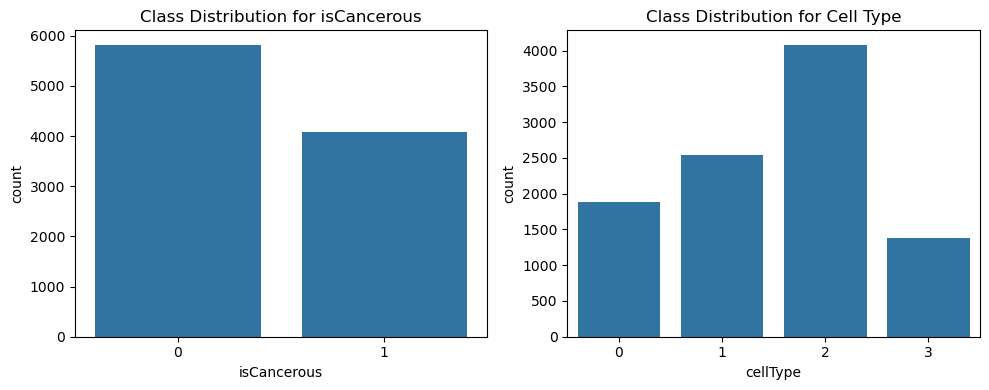


--- Checking for Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

--- Summary Statistics for Main Data ---
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000     1.000000     0.000000
50%     9279.500000    26.000000     2.000000     0.000000
75%    16821.250000    47.000000     2.000000     1.000000
max    22444.000000    60.000000     3.000000     1.000000
Displaying sample images from the dataset:


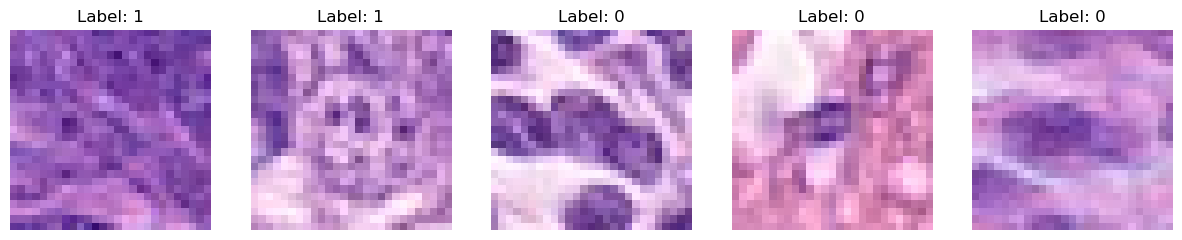

isCancerous
0    0.587813
1    0.412187
Name: proportion, dtype: float64
cellType
2    0.412187
1    0.256973
0    0.190784
3    0.140057
Name: proportion, dtype: float64


In [18]:
""# Colon Cancer Image Classification Project
# Step 1: Data Loading and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Paths to CSV files and Image folder
MAIN_DATA_CSV = 'data_labels_mainData.csv'
EXTRA_DATA_CSV = 'data_labels_extraData.csv'
IMAGE_FOLDER = 'patch_images/'

# Load CSV data
main_data = pd.read_csv(MAIN_DATA_CSV)
extra_data = pd.read_csv(EXTRA_DATA_CSV)

# Display basic info
print('Main Data Information:')
print(main_data.info())
print('\nExtra Data Information:')
print(extra_data.info())

# Display first few rows
print('\nMain Data Sample:')
print(main_data.head())
print('\nExtra Data Sample:')
print(extra_data.head())

# Check class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='isCancerous', data=main_data)
plt.title('Class Distribution for isCancerous')
plt.subplot(1, 2, 2)
sns.countplot(x='cellType', data=main_data)
plt.title('Class Distribution for Cell Type')
plt.tight_layout()
plt.show()

# Function to load and display a few images
def display_sample_images(df, image_folder, num_samples=5):
    samples = df.sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, row in enumerate(samples.iterrows()):
        img_path = os.path.join(image_folder, row[1]['ImageName'])
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f"Label: {row[1]['isCancerous']}")
        plt.axis('off')
    plt.show()

# Checking for Missing Values
print("\n--- Checking for Missing Values ---")
print(main_data.isnull().sum())

# Summary Statistics for Main Data
print("\n--- Summary Statistics for Main Data ---")
print(main_data.describe())


# Display some sample images
print("Displaying sample images from the dataset:")
display_sample_images(main_data, IMAGE_FOLDER)
# Checking class balance
print(main_data['isCancerous'].value_counts(normalize=True))
print(main_data['cellType'].value_counts(normalize=True))



There is an imbalance between non cancerous (58.78 %) in comparison to cancerous (41.22%), meaning the modelk may be bias towards non cancerous. 

This means careful metric selection and data balancing is needed to ensure cancerous cases aren't overlooked

The cellType shows a clear imbalance across its four categories. Type 2 is the most prevalent (41.22%), while Type 3 is the least represented (14.01%). This imbalance could bias the model to perform better on Type 2 cells while misclassifying less represented types, such as Type 3. To mitigate this, class balancing strategies such as augmentation or class-weight adjustments will be considered during model training.

additionally from the sample images, blur looks like a potential issue

In [19]:
from sklearn.model_selection import train_test_split

patient_ids = main_data['patientID'].unique()


train_x, temp_x = train_test_split(patient_ids, test_size=0.3, random_state=42)


val_x, test_x = train_test_split(temp_x, test_size=0.5, random_state=42)

train_Data = main_data[main_data['patientID'].isin(train_x)]
val_Data = main_data[main_data['patientID'].isin(val_x)]
test_Data = main_data[main_data['patientID'].isin(test_x)]

print(f"Train: {len(train_Data)}, Val: {len(val_Data)}, Test: {len(test_Data)}")

train_patients_set = set(train_x)
val_patients_set = set(val_x)
test_patients_set = set(test_x)

overlap_train_val = train_patients_set.intersection(val_patients_set)
overlap_train_test = train_patients_set.intersection(test_patients_set)
overlap_val_test = val_patients_set.intersection(test_patients_set)

print(f"Train-Val Overlap: {overlap_train_val}")
print(f"Train-Test Overlap: {overlap_train_test}")
print(f"Val-Test Overlap: {overlap_val_test}")


Train: 6778, Val: 1257, Test: 1861
Train-Val Overlap: set()
Train-Test Overlap: set()
Val-Test Overlap: set()


6778 + 1257 + 1861 = 9896, which matches with amount of patients count from earlier. Meaning there should be no overlap but I did additionally make a method to ensure there is no overlap

F1-score will be used as the primary evaluation metric because it balances precision and recall, making it more suitable for imbalanced datasets where accuracy can be misleading.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# train_Data = train_Data.copy()
# val_Data = val_Data.copy()
# test_Data = test_Data.copy()

# train_Data.loc[:, 'isCancerous_str'] = train_Data['isCancerous'].astype(str)
# val_Data.loc[:, 'isCancerous_str'] = val_Data['isCancerous'].astype(str)
# test_Data.loc[:, 'isCancerous_str'] = test_Data['isCancerous'].astype(str)

# train_Datagen = ImageDataGenerator(
#     rescale=1./255
# )

# val_test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_Datagen.flow_from_dataframe(
#     train_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# val_generator = val_test_datagen.flow_from_dataframe(
#     val_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# test_generator = val_test_datagen.flow_from_dataframe(
#     test_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )
# #checking to see if tensor detects my gpu 
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# from tensorflow.keras import layers, models
# #since this is binary, lamda iun't needed yet
# def create_cnn_model():
#     model = models.Sequential([
#         layers.Input(shape=(224, 224, 3)),
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# def create_mlp_model():
#     model = models.Sequential([
#         layers.Input(shape=(224, 224, 3)),
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# from tensorflow.keras import optimizers
# from tensorflow.keras.callbacks import EarlyStopping

# cnn_model = create_cnn_model()
# cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


# mlp_model = create_mlp_model()
# mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

# early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# history_cnn = cnn_model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     callbacks=[early_stop]
# )

# history_mlp = mlp_model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     callbacks=[early_stop]
# )

# def plot_learning_curves(history, model_name):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Val Loss')
#     plt.title(f'{model_name} Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#     plt.title(f'{model_name} Accuracy')
#     plt.legend()
#     plt.show()

# plot_learning_curves(history_cnn, 'CNN')

# plot_learning_curves(history_mlp, 'MLP')

# from sklearn.metrics import f1_score, classification_report

# test_preds_cnn = cnn_model.predict(test_generator)
# test_preds_cnn_labels = (test_preds_cnn > 0.5).astype(int)

# test_preds_mlp = mlp_model.predict(test_generator)
# test_preds_mlp_labels = (test_preds_mlp > 0.5).astype(int)

# true_labels = test_generator.classes

# f1_cnn = f1_score(true_labels, test_preds_cnn_labels)
# f1_mlp = f1_score(true_labels, test_preds_mlp_labels)

# print(f'CNN Test F1-Score: {f1_cnn:.4f}')
# print(f'MLP Test F1-Score: {f1_mlp:.4f}')


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_Data = train_Data.copy()
val_Data = val_Data.copy()
test_Data = test_Data.copy()

train_Data['cellType_str'] = train_Data['cellType'].astype(str)
val_Data['cellType_str'] = val_Data['cellType'].astype(str)
test_Data['cellType_str'] = test_Data['cellType'].astype(str)

train_generator_ct = train_Datagen.flow_from_dataframe(
    train_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_ct = val_test_datagen.flow_from_dataframe(
    val_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_ct = val_test_datagen.flow_from_dataframe(
    test_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


def create_cnn_model_multiclass():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model

def create_mlp_model_multiclass():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model

from tensorflow.keras.losses import CategoricalCrossentropy

cnn_model_ct = create_cnn_model_multiclass()
cnn_model_ct.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=CategoricalCrossentropy(),
                    metrics=['categorical_accuracy'])

mlp_model_ct = create_mlp_model_multiclass()
mlp_model_ct.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=CategoricalCrossentropy(),
                    metrics=['categorical_accuracy'])

# Train with EarlyStopping
history_cnn_ct = cnn_model_ct.fit(
    train_generator_ct,
    validation_data=val_generator_ct,
    epochs=30,
    callbacks=[early_stop]
)

history_mlp_ct = mlp_model_ct.fit(
    train_generator_ct,
    validation_data=val_generator_ct,
    epochs=30,
    callbacks=[early_stop]
)

from sklearn.metrics import f1_score

# Predict CNN
cnn_preds_ct = cnn_model_ct.predict(test_generator_ct)
cnn_preds_ct_labels = cnn_preds_ct.argmax(axis=1)

# Predict MLP
mlp_preds_ct = mlp_model_ct.predict(test_generator_ct)
mlp_preds_ct_labels = mlp_preds_ct.argmax(axis=1)

# True labels
true_labels_ct = test_generator_ct.classes

# F1 Scores
f1_cnn_ct = f1_score(true_labels_ct, cnn_preds_ct_labels, average='weighted')
f1_mlp_ct = f1_score(true_labels_ct, mlp_preds_ct_labels, average='weighted')

print(f'CNN cellType F1-Score: {f1_cnn_ct:.4f}')
print(f'MLP cellType F1-Score: {f1_mlp_ct:.4f}')

Found 6778 validated image filenames belonging to 4 classes.
Found 1257 validated image filenames belonging to 4 classes.
Found 1861 validated image filenames belonging to 4 classes.
Epoch 1/30


c:\Users\micro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 94s 438ms/step - categorical_accuracy: 0.4612 - loss: 3.1244 - val_categorical_accuracy: 0.6969 - val_loss: 0.8245
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 92s 434ms/step - categorical_accuracy: 0.6783 - loss: 0.8149 - val_categorical_accuracy: 0.6683 - val_loss: 0.8472
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 92s 433ms/step - categorical_accuracy: 0.6968 - loss: 0.7724 - val_categorical_accuracy: 0.7033 - val_loss: 0.8005
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 91s 432ms/step - categorical_accuracy: 0.7432 - loss: 0.6513 - val_categorical_accuracy: 0.6874 - val_loss: 0.8539
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 94s 442ms/step - categorical_accuracy: 0.7760 - loss: 0.5760 - val_categorical_accuracy: 0.6913 - val_loss: 0.8325
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 409ms/step - categorical_accuracy: 0.8127 - loss: 0.4894 - val_categorical_accuracy: 0.6850 - val_loss: 0.8649
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 408ms/step - categorical_accuracy: 0.

About data leakages

As with all things involving the medical field, avoiding patient-based data leakage is paramount. There’s serious risks that a model trained on data from outside the training set, will respond poorly on future data. For example if the model is performing impressively during training and validation, but when testing it on real world data it entirely misses targets and has poor accuracy. 

One method to reduce data leakage without risking a loss of confidentiality would be to use some kind of encryption for patient data. In this way, a patient’s ID can be attached to data even within databases, without a risk of losing confidentiality. If a patient’s ID was encrypted, then you could compare the encrypted strings in order to ensure that no data is being leaked between sets, whilst also maintaining the confidentiality of the patient’s sensitive information. 

Another method to reduce data leakage would be to introduce heavy auditing of data. If a model is showing unexpected patterns in prediction, or looks to be performing in an atypical way for the data it's being trained on, it could use a deeper investigation in order to maintain its accuracy and its scope towards only the expected train data. If the model starts to show worse signs of performance as its being introduced to new data, it gives a strong correlation that earlier training and metrics that were used on the model could have data leakage within them. 
